# <font color='#1a5276'> <b> <center> Deep Neural Networks </center> </b> </font>

## <font color='blue'>  Table of Contents </font>

1. [Introduction](#1)
2. [Setup](#2)
3. [Example 1](#3) <br>
    3.1. [Data](#3.1) <br>
    3.2. [Model architecture and training](#3.2) <br>
    3.3. [Model comparisson](#3.3) <br>
4. [Example 2](#4) <br>
    4.1. [Helper Functions](#4.1) <br>
    4.2. [Data](#4.2) <br>
    4.3. [Model architecture, training and evaluation](#4.3) <br>
5. [Annex](#annex)
6. [References](#references)

<a name="1"></a>
## <font color='blue'> <b> 1. Introduction </b> </font>

This notebook demonstrates how to train a simple deep neural network using PyTorch. It covers the steps of defining the neural network architecture, selecting an activation function, setting up the loss function and optimizer, and training the model on a sample dataset.

<a name="2"></a>
## <font color='blue'> <b> 2. Setup </b> </font>

In [3]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [67]:
import torch 
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as dsets
import torch.nn.functional as F
import matplotlib.pylab as plt
import numpy as np
from torch.utils.data import Dataset, DataLoader
from matplotlib.colors import ListedColormap

In [5]:
torch.manual_seed(2)

<a name="3"></a>
## <font color='blue'> <b> 3. Example 1 </b> </font>

We will create a net with 2 hidden layers.

<a name="3.1"></a>
### <font color='#1a5276'> <b> 3.1. Data </b> </font>

In [7]:
# Create the training dataset
train_dataset = dsets.MNIST(root='./', train=True, download=True, transform=transforms.ToTensor())

# Create the validating dataset
validation_dataset = dsets.MNIST(root='./', train=False, download=True, transform=transforms.ToTensor())

In [8]:
# Create the training data loader and validation data loader object
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=2000, shuffle=True)
validation_loader = torch.utils.data.DataLoader(dataset=validation_dataset, batch_size=5000, shuffle=False)

<a name="3.2"></a>
### <font color='#1a5276'> <b> 3.2. Model architecture and training </b> </font>

In [10]:
class Net(nn.Module):
    """
    A simple feedforward neural network with two hidden layers.
    
    Args:
    - D_in (int): The number of input features.
    - H1 (int): The number of neurons in the first hidden layer.
    - H2 (int): The number of neurons in the second hidden layer.
    - D_out (int): The number of output features.
    - activation_function (nn.Module, optional): The activation function to be used between layers. Default is Sigmoid.

    The network consists of:
    - Linear layer 1: From D_in to H1.
    - Linear layer 2: From H1 to H2.
    - Linear layer 3: From H2 to D_out.
    """
    
    # Constructor
    def __init__(self, D_in, H1, H2, D_out, activation_function=nn.Sigmoid()):
        """
        Initializes the neural network layers and the activation function.
        
        Args:
        - D_in (int): Number of input features.
        - H1 (int): Number of neurons in the first hidden layer.
        - H2 (int): Number of neurons in the second hidden layer.
        - D_out (int): Number of output features.
        - activation_function (nn.Module, optional): The activation function to apply after each hidden layer.
        """
        super(Net, self).__init__()
        # Define the layers
        self.linear1 = nn.Linear(D_in, H1)  # First hidden layer
        self.linear2 = nn.Linear(H1, H2)  # Second hidden layer
        self.linear3 = nn.Linear(H2, D_out)  # Output layer
        
        self.activation_function = activation_function  # Store the activation function
    
    # Prediction
    def forward(self, x):
        """
        Defines the forward pass of the network.
        
        Args:
        - x (torch.Tensor): The input tensor to the network.
        
        Returns:
        - torch.Tensor: The output tensor after applying the forward pass.
        """
        # Apply activation function to the output of the first hidden layer
        x = self.activation_function(self.linear1(x))
        
        # Apply activation function to the output of the second hidden layer
        x = self.activation_function(self.linear2(x))
        
        # Output from the final linear layer (no activation function)
        x = self.linear3(x)
        
        return x


In [11]:
# Training function
def train(model, criterion, train_loader, validation_loader, optimizer, epochs=100):
    """
    Trains a neural network model using the given training data, optimizer, and loss function.
    
    Args:
    - model (nn.Module): The neural network model to train.
    - criterion (nn.Module): The loss function used for training.
    - train_loader (DataLoader): A DataLoader that provides the training data.
    - validation_loader (DataLoader): A DataLoader that provides the validation data.
    - optimizer (Optimizer): The optimizer to update the model's weights.
    - epochs (int, optional): The number of epochs to train the model. Default is 100.
    
    Returns:
    - dict: A dictionary containing two lists:
        - 'training_loss': A list of the training loss values for each iteration.
        - 'validation_accuracy': A list of the validation accuracy values at the end of each epoch.
    - model: The trained model.
    """
    i = 0
    # Dictionary to store the training loss and validation accuracy
    metrics = {'training_loss': [], 'validation_accuracy': []}  
    
    # Loop through the number of epochs
    for epoch in range(epochs):
        # Training phase
        for i, (x, y) in enumerate(train_loader):
            optimizer.zero_grad()  # Reset the gradients
            yhat = model(x.view(-1, 28 * 28))  # Forward pass (flatten input)
            loss = criterion(yhat, y)  # Compute the loss
            loss.backward()  # Backpropagation
            optimizer.step()  # Update the model's parameters
            metrics['training_loss'].append(loss.data.item())  # Store the loss
            
        # Validation phase
        correct = 0
        for x, y in validation_loader:
            yhat = model(x.view(-1, 28 * 28))  # Forward pass (flatten input)
            _, label = torch.max(yhat, 1)  # Get the predicted label
            correct += (label == y).sum().item()  # Count correct predictions
        
        # Calculate validation accuracy
        accuracy = 100 * (correct / len(validation_dataset))
        metrics['validation_accuracy'].append(accuracy)  # Store the accuracy
    
    return metrics, model


In [14]:
input_dim = 28 * 28 # 28x28 greyscale images
hidden_dim1 = 50 # number of units of the first hidden layer
hidden_dim2 = 50 # number of units of the second hidden layer
output_dim = 10 # 10 outputs (digits from 0 to 9)
epochs = 10
learning_rate = 0.01

In [15]:
# criterion
criterion = nn.CrossEntropyLoss()

We will try different models, each with a different activation function.

### Model 1:sigmoid

In [20]:
model_sigmoid = Net(input_dim, hidden_dim1, hidden_dim2, output_dim)

optimizer = torch.optim.SGD(model_sigmoid.parameters(), lr=learning_rate)

metrics_sigmoid, trained_model_sigmoid = train(model_sigmoid, criterion, train_loader, 
                                               validation_loader, optimizer, epochs=epochs)

### Model 2: tanh

In [17]:
# Train the model with tanh function

model_tanh = Net(input_dim, hidden_dim1, hidden_dim2, output_dim, activation_function=nn.Tanh())

optimizer = torch.optim.SGD(model_tanh.parameters(), lr=learning_rate)

metrics_tanh, trained_model_tanh = train(model_tanh, criterion, train_loader, 
                                         validation_loader, optimizer, epochs=epochs)

### Model 3: ReLU

In [22]:
# Train the model with relu function

model_relu = Net(input_dim, hidden_dim1, hidden_dim2, output_dim, activation_function=nn.ReLU())

optimizer = torch.optim.SGD(model_relu.parameters(), lr=learning_rate)

metrics_relu, trained_model_relu = train(model_relu, criterion, train_loader, 
                                         validation_loader, optimizer, epochs=epochs)

<a name="3.3"></a>
### <font color='#1a5276'> <b> 3.3. Model comparisson </b> </font>

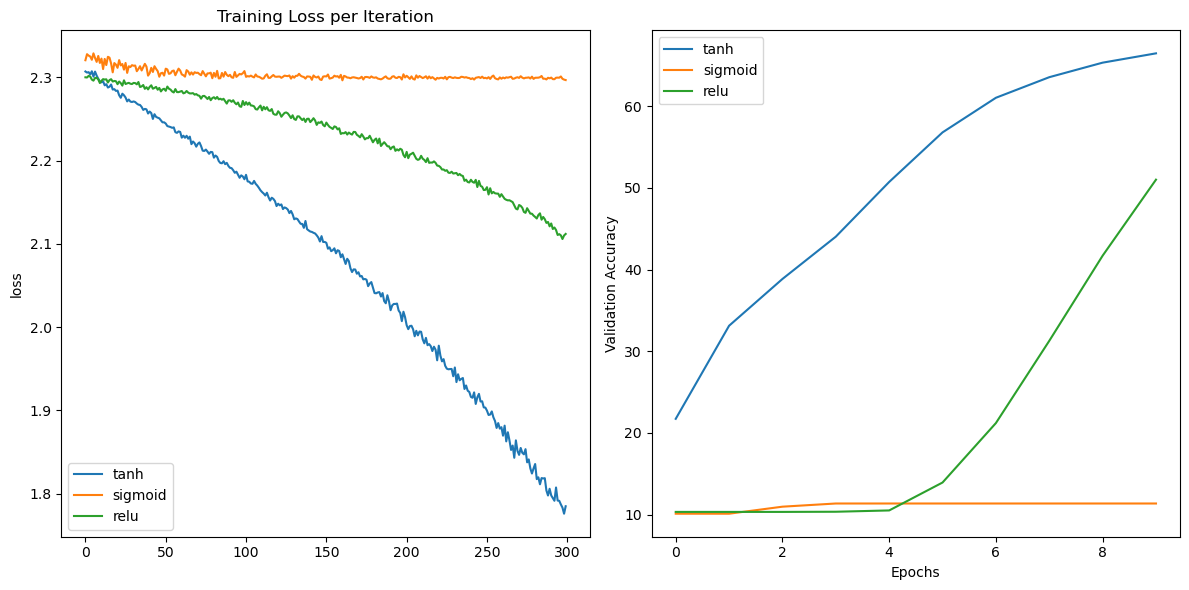

In [25]:
# Create a figure and a 1x2 grid of subplots (side by side)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Plot training loss on the first subplot (ax1)
ax1.plot(metrics_tanh['training_loss'], label='tanh')
ax1.plot(metrics_sigmoid['training_loss'], label='sigmoid')
ax1.plot(metrics_relu['training_loss'], label='relu')
ax1.set_ylabel('loss')
ax1.set_title('Training Loss per Iteration')
ax1.legend()

# Plot validation accuracy on the second subplot (ax2)
ax2.plot(metrics_tanh['validation_accuracy'], label='tanh')
ax2.plot(metrics_sigmoid['validation_accuracy'], label='sigmoid')
ax2.plot(metrics_relu['validation_accuracy'], label='relu')
ax2.set_ylabel('Validation Accuracy')
ax2.set_xlabel('Epochs')
ax2.legend()

# Adjust layout for better spacing between subplots
plt.tight_layout()

# Display the plots
plt.show()

<a name="4"></a>
## <font color='blue'> <b> 4. Example 2 </b> </font>

<a name="4.1"></a>
### <font color='#1a5276'> <b> 4.1. Helper Functions </b> </font>

In [57]:
# Plot decision regions
def plot_decision_regions_3class(model, dataset):
    # Define color maps for decision regions and class labels
    cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA', '#00AAFF'])  # For decision regions
    cmap_bold = ListedColormap(['#FF0000', '#00FF00', '#00AAFF'])   # For class points
    
    # Convert dataset to numpy arrays
    X = dataset.x.numpy()  # Input features
    y = dataset.y.numpy()  # Ground truth labels
    
    h = .02  # Step size in meshgrid
    
    # Set axis limits based on input feature values
    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
    
    # Create meshgrid for plotting decision regions
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    
    # Create a tensor from meshgrid and make predictions using the model
    XX = torch.Tensor(np.c_[xx.ravel(), yy.ravel()])
    _, yhat = torch.max(model(XX), 1)  # Get predicted class labels
    yhat = yhat.numpy().reshape(xx.shape)  # Reshape predictions for meshgrid
    
    # Plot the decision regions
    plt.pcolormesh(xx, yy, yhat, cmap=cmap_light)
    
    # Plot individual data points for each class with different colors
    plt.plot(X[y[:] == 0, 0], X[y[:] == 0, 1], 'ro', label = 'y=0')  # Class 0 in red
    plt.plot(X[y[:] == 1, 0], X[y[:] == 1, 1], 'go', label = 'y=1')  # Class 1 in green
    plt.plot(X[y[:] == 2, 0], X[y[:] == 2, 1], 'o', label = 'y=2')   # Class 2 in blue
    
    # Set title and display the legend
    plt.title("Decision Region")
    plt.legend()

    
    
# Calculate accuracy
def accuracy(model, dataset):
    _, yhat = torch.max(model(dataset.x), 1)
    return (yhat == dataset.y).numpy().mean()

<a name="4.2"></a>
### <font color='#1a5276'> <b> 4.2. Data </b> </font>

In [49]:
class Data(Dataset):
    
    # Constructor
    def __init__(self, K=3, N=500):
        D = 2  # Dimensionality of the data (2D points)
        
        # Initialize the data matrix (each row is a single example)
        X = np.zeros((N * K, D))  # Data matrix (N*K samples, 2 features)
        
        # Initialize the class labels (K classes)
        y = np.zeros(N * K, dtype='uint8')  # Labels for each data point
        
        # Create synthetic data for K classes
        for j in range(K):
            ix = range(N * j, N * (j + 1))  # Define indices for the current class
            r = np.linspace(0.0, 1, N)  # Generate radii (range from 0 to 1)
            t = np.linspace(j * 4, (j + 1) * 4, N) + np.random.randn(N) * 0.2  # Generate angles (theta) with some noise
            
            # Create 2D points using polar coordinates (r, t)
            X[ix] = np.c_[r * np.sin(t), r * np.cos(t)]
            y[ix] = j  # Assign the current class label
            
        # Convert data and labels to PyTorch tensors
        self.y = torch.from_numpy(y).type(torch.LongTensor)  # Convert labels to LongTensor
        self.x = torch.from_numpy(X).type(torch.FloatTensor)  # Convert data to FloatTensor
        self.len = y.shape[0]  # Length of the dataset (total number of samples)
    
    # Getter function to retrieve a sample by index
    def __getitem__(self, index):
        return self.x[index], self.y[index]  # Return the data and the label for the given index
    
    # Function to get the length of the dataset (total number of samples)
    def __len__(self):
        return self.len  # Return the total number of samples
    
    # Function to plot the dataset
    def plot_stuff(self):
        # Plot the data points for each class with different colors and markers
        plt.plot(self.x[self.y[:] == 0, 0].numpy(), self.x[self.y[:] == 0, 1].numpy(), 'o', label="y = 0")  # Class 0
        plt.plot(self.x[self.y[:] == 1, 0].numpy(), self.x[self.y[:] == 1, 1].numpy(), 'ro', label="y = 1")  # Class 1
        plt.plot(self.x[self.y[:] == 2, 0].numpy(), self.x[self.y[:] == 2, 1].numpy(), 'go', label="y = 2")  # Class 2
        
        # Add a legend to distinguish between the classes
        plt.legend()


In [50]:
# Create a Data object
dataset = Data()

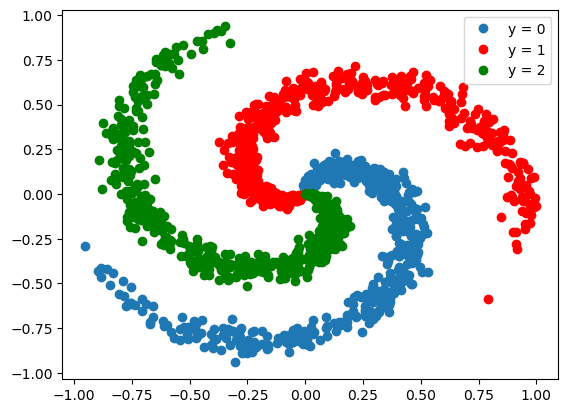

In [51]:
# plot
dataset.plot_stuff()

In [63]:
# train loader
train_loader = DataLoader(dataset=dataset, batch_size=20)

<a name="4.3"></a>
### <font color='#1a5276'> <b> 4.3. Model architecture, training and evaluation </b> </font>

We will build a deep net using [nn.ModuleList](https://pytorch.org/docs/stable/generated/torch.nn.ModuleList.html)


<img src="images/deep_net.png"/>

<br>

In [55]:
class Net(nn.Module):
    """
    A simple feedforward neural network class in PyTorch.

    This class defines a neural network with multiple hidden layers. The number of 
    layers and the number of neurons in each layer are provided as input through 
    the `Layers` parameter. It uses ReLU activation for all layers except the last one.

    Args:
        Layers (list): A list of integers representing the number of neurons in each layer. 
                        The first element is the input layer size, and the last element is the output layer size.
    """

    # Constructor
    def __init__(self, Layers):
        """
        Initializes the network by creating hidden layers based on the given 'Layers' list.
        
        Args:
            Layers (list): A list where each element represents the number of neurons in a layer.
        """
        super(Net, self).__init__()
        
        # Initialize a list to store hidden layers
        self.hidden = nn.ModuleList()
        
        # Create linear layers for the hidden layers
        for input_size, output_size in zip(Layers, Layers[1:]):
            # Append a linear transformation (fully connected layer) to the hidden list
            self.hidden.append(nn.Linear(input_size, output_size))

    # Forward pass
    def forward(self, activation):
        """
        Defines the forward pass of the neural network.

        For each hidden layer, the activation is passed through a linear transformation
        followed by a ReLU activation function, except for the last layer which does not 
        use an activation function.

        Args:
            activation (Tensor): The input tensor that is passed through the network.

        Returns:
            Tensor: The output of the network after the forward pass.
        """
        L = len(self.hidden)  # Number of hidden layers
        
        # Loop through each layer
        for l, linear_transform in zip(range(L), self.hidden):
            if l < L - 1:  # For all layers except the last one, apply ReLU activation
                activation = F.relu(linear_transform(activation))
            else:
                # For the last layer, just apply the linear transformation
                activation = linear_transform(activation)
        
        # Return the final output after passing through all layers
        return activation


In [56]:
def train(data_set, model, criterion, train_loader, optimizer, epochs=100):
    """
    Trains a neural network model, tracks its loss and accuracy, and plots them.

    Args:
    - data_set: The dataset used for evaluating accuracy.
    - model: The neural network model to be trained.
    - criterion: The loss function to evaluate the model's performance.
    - train_loader: DataLoader object that provides the training data.
    - optimizer: The optimization algorithm used to update model parameters.
    - epochs (int): The number of training iterations (default is 100).

    Returns:
    - loss (list): A list containing the total loss at each iteration.
    - model (Model): The trained model.
    """
    loss = []  # List to store the loss values for each iteration
    acc = []   # List to store the accuracy values for each epoch
    
    # Loop over the number of epochs
    for epoch in range(epochs):
        # Loop over batches of data in the training set
        for x, y in train_loader:
            optimizer.zero_grad()  # Clear gradients from previous iteration
            yhat = model(x)  # Forward pass: Compute predicted y (model output)
            loss_value = criterion(yhat, y)  # Calculate the loss
            optimizer.zero_grad()  # Clear any previously accumulated gradients (not necessary here)
            loss_value.backward()  # Backward pass: Compute gradient of the loss
            optimizer.step()  # Update model parameters based on gradients
            loss.append(loss_value.item())  # Append the loss value to the loss list

        # Calculate and store the accuracy after each epoch
        acc.append(accuracy(model, data_set)) 
    
    # Create the plot to visualize loss and accuracy
    fig, ax1 = plt.subplots()
    
    # Plot the loss on the left y-axis
    color = 'tab:red'
    ax1.plot(loss, color=color)  # Plot total loss over iterations
    ax1.set_xlabel('Iteration', color=color)  # Set the x-axis label
    ax1.set_ylabel('Total Loss', color=color)  # Set the left y-axis label for loss
    ax1.tick_params(axis='y', color=color)  # Set the color of y-axis ticks for loss
    
    # Create a second y-axis to plot accuracy
    ax2 = ax1.twinx()  
    color = 'tab:blue'
    ax2.set_ylabel('Accuracy', color=color)  # Set the right y-axis label for accuracy
    ax2.plot(acc, color=color)  # Plot accuracy over epochs
    ax2.tick_params(axis='y', color=color)  # Set the color of y-axis ticks for accuracy

    # Adjust layout so labels are not clipped
    fig.tight_layout() 
    
    # Display the plot
    plt.show()

    # Return the loss values
    return loss, model


In [59]:
# constants
input_size = 2
output_size = 3
learning_rate = 0.1

In [60]:
# criterion
criterion = nn.CrossEntropyLoss()

### Model 1

One hidden layer with 50 neurons.

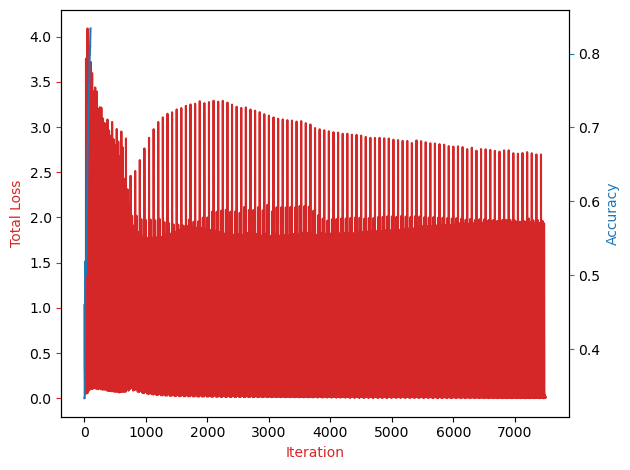

In [65]:
# number of neiurons in each layer
layers = [input_size, 50, output_size]

# model
model = Net(layers)

# optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

# training
loss_model_1, trained_model_1 = train(dataset, model, criterion, train_loader, optimizer, epochs=100)

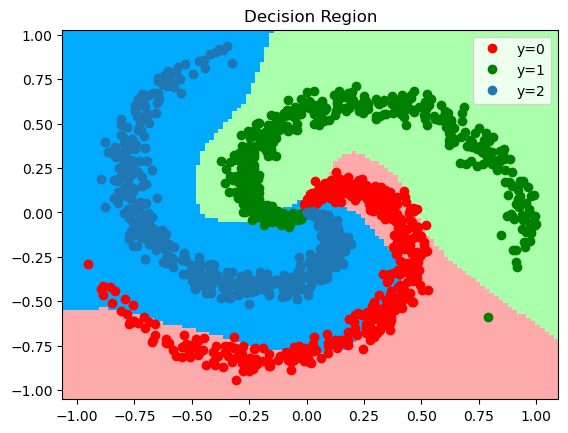

In [68]:
# plot decision regions
plot_decision_regions_3class(trained_model_1, dataset)

In [72]:
# accuracy
print(f"Model 1 accuracy: {accuracy(trained_model_1, dataset)}")

Model 1 accuracy: 0.834


### Model 2

2 hidden layers with 10 neurons each.


<img src="images/example_net.png"/>

<br>


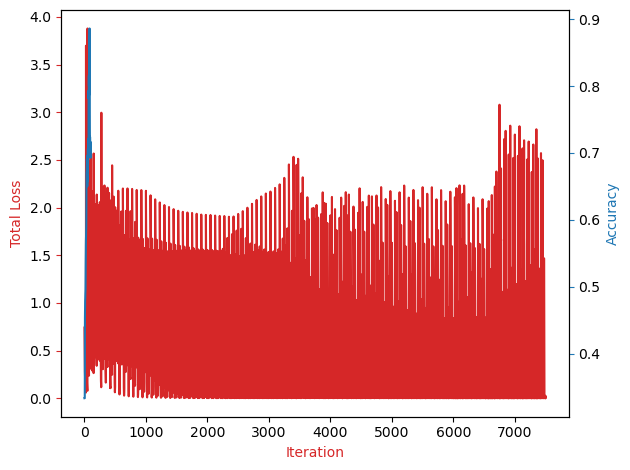

In [78]:
layers = [input_size, 10, 10, output_size]

model_2 = Net(layers)

optimizer_2 = torch.optim.SGD(model_2.parameters(), lr=learning_rate)

loss_model_2, trained_model_2 = train(dataset, model_2, criterion, train_loader, optimizer_2, epochs=100)


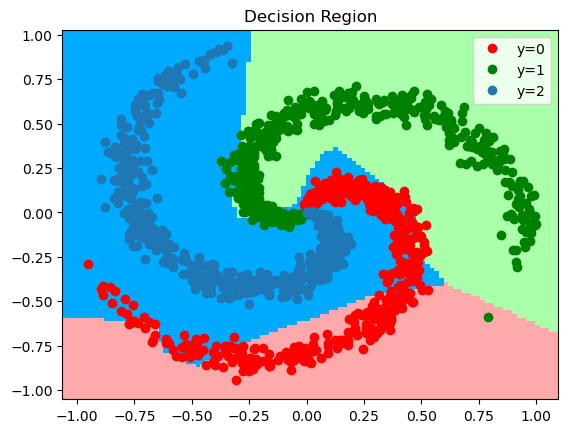

In [79]:
plot_decision_regions_3class(trained_model_2, dataset)

In [80]:
# accuracy
print(f"Model 2 accuracy: {accuracy(trained_model_2, dataset)}")

Model 2 accuracy: 0.7033333333333334


We get better results with the first model.

<a name="annex"></a>
## <font color='blue'> <b> Annex </b> </font>

Plot a neural network with matplotlib.

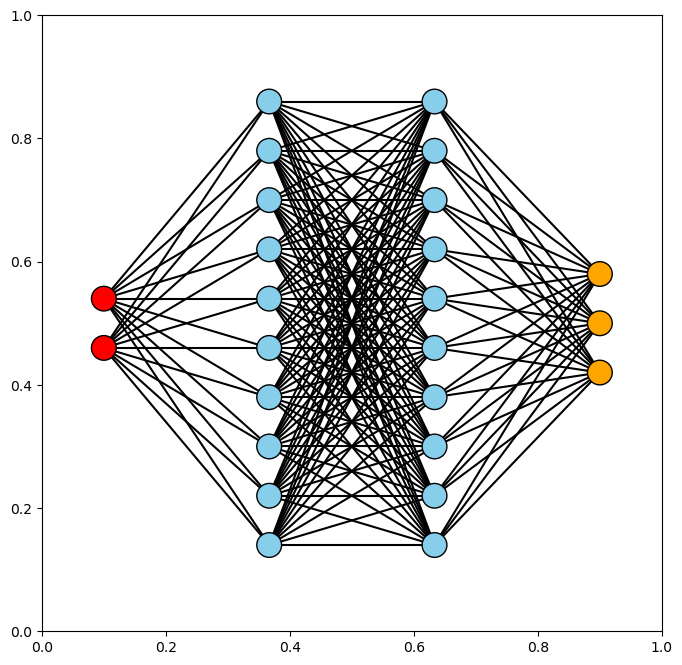

In [84]:
# code adapted from #https://gist.github.com/craffel/2d727968c3aaebd10359
def draw_neural_net(ax, left, right, bottom, top, layer_sizes):
    '''
    Draw a neural network cartoon using matplotlib with customized colors for the input, hidden, and output layers.
    
    :usage:
        >>> fig = plt.figure(figsize=(12, 12))
        >>> draw_neural_net(fig.gca(), .1, .9, .1, .9, [4, 7, 2])
    
    :parameters:
        - ax : matplotlib.axes.AxesSubplot
            The axes on which to plot the cartoon (get e.g. by plt.gca())
        - left : float
            The center of the leftmost node(s) will be placed here
        - right : float
            The center of the rightmost node(s) will be placed here
        - bottom : float
            The center of the bottommost node(s) will be placed here
        - top : float
            The center of the topmost node(s) will be placed here
        - layer_sizes : list of int
            List of layer sizes, including input and output dimensionality
    '''
    n_layers = len(layer_sizes)
    v_spacing = (top - bottom)/float(max(layer_sizes))
    h_spacing = (right - left)/float(len(layer_sizes) - 1)
    
    # Colors for input, hidden, and output layers
    layer_colors = ['red', 'skyblue', 'orange']  # Input, Hidden, Output

    # Nodes
    for n, layer_size in enumerate(layer_sizes):
        layer_top = v_spacing*(layer_size - 1)/2. + (top + bottom)/2.
        for m in range(layer_size):
            # Determine the color for each layer
            if n == 0:
                color = 'red'  # Input layer color
            elif n == len(layer_sizes) - 1:
                color = 'orange'  # Output layer color
            else:
                color = 'skyblue'  # Hidden layer color
            
            # Create a circle for each node
            circle = plt.Circle((n*h_spacing + left, layer_top - m*v_spacing), v_spacing/4.,
                                color=color, ec='k', zorder=4)
            ax.add_artist(circle)
    
    # Edges
    for n, (layer_size_a, layer_size_b) in enumerate(zip(layer_sizes[:-1], layer_sizes[1:])):
        layer_top_a = v_spacing*(layer_size_a - 1)/2. + (top + bottom)/2.
        layer_top_b = v_spacing*(layer_size_b - 1)/2. + (top + bottom)/2.
        for m in range(layer_size_a):
            for o in range(layer_size_b):
                # Create a line for each connection between nodes
                line = plt.Line2D([n*h_spacing + left, (n + 1)*h_spacing + left],
                                  [layer_top_a - m*v_spacing, layer_top_b - o*v_spacing], c='k')
                ax.add_artist(line)

# Example usage
fig = plt.figure(figsize=(8, 8))
draw_neural_net(fig.gca(), .1, .9, .1, .9, [2, 10, 10, 3])
plt.show()


<a name="references"></a>
## <font color='blue'> <b> References </b> </font>

[IBM AI Engineering Professional Certificate](https://www.coursera.org/professional-certificates/ai-engineer)

[PyTorch Documentation](https://pytorch.org/docs/stable/index.html)